In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp

#%matplotlib widget

In [2]:
HEADER = ['F3', 'Fz', 'F4', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'P3', 'Pz', 'P4', 'Oz', 'Photoresistor']
tsv = pd.read_csv("../data/EEG Data.csv", sep="\t", names=HEADER)

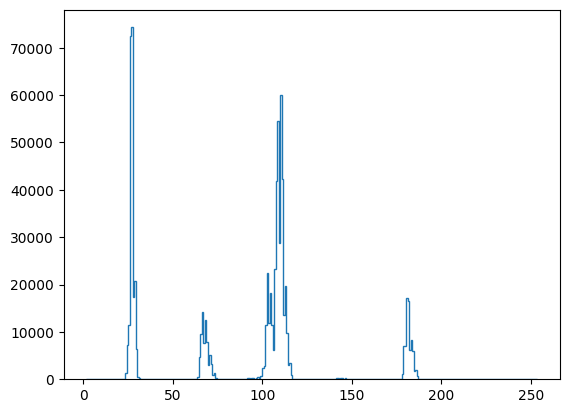

In [3]:
pr = tsv["Photoresistor"].to_numpy()
tsv["Photoresistor"].to_csv("../data/photoresistor.csv")

bins, count = np.histogram(pr, bins=300)

plt.close()
plt.stairs(bins, count)
plt.show()

In [4]:

"""
Reading the csv generated by the protocol program, we know that:
- The first action was the right hand
- The right hand option is paired with up (both hands)
- The first reponse was HIGH (so ACTION_2)
- Each action was recorded (15 samples per set) * 5 (set count) * 2 (action + imagined) = 150

Also, through value analysis, values before 5300 and after 745900 shouldn't be used, since they are after the experiment end.

Useful numbers to know:
- Expected n of high samples = low samples = 150 * 2 = 300
- Expected n of rests = n high samples + n low samples = 600
- Expected n of pauses = n sets + 1 = 7
"""
data = tsv.to_numpy()[5300:751200, :].T # Should still be useful to use a numpy instead of dict to faster filter processing
pr = data[len(data)-1]
pr = scp.signal.medfilt(pr, 29)

getfirst = lambda x: np.where(x.astype(int) - np.concatenate([[True], x[:-1]]).astype(int) == 1)[0]
getlast = lambda x: np.where(x.astype(int) - np.concatenate([[False], x[:-1]]).astype(int) == -1)[0]

20


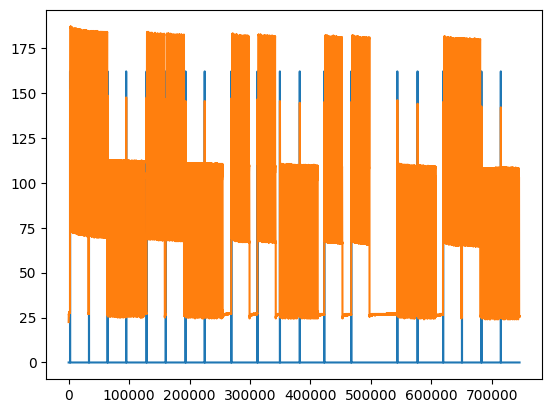

In [5]:
CYAN_MIN = 140
CYAN_MAX = 152

cyan_samples = np.logical_and(pr < CYAN_MAX, pr > CYAN_MIN)
cyan_starts = getfirst(cyan_samples)
cyan_ends = getlast(cyan_samples)

cyan_indexes_wanted = np.where(np.logical_and(pr[cyan_ends + 2] < CYAN_MAX, pr[cyan_starts - 2] < CYAN_MAX))[0]
cyan_starts = cyan_starts[cyan_indexes_wanted]
cyan_ends = cyan_ends[cyan_indexes_wanted]
print(len(cyan_starts))

cyan_plot = np.zeros(pr.shape)
cyan_plot[cyan_starts] = CYAN_MAX + 10
plt.close()
plt.plot(cyan_plot)
plt.plot(pr)
plt.show()

In [6]:
collection_ends = np.concatenate([cyan_starts[1:], [len(pr)]])

task1_indexes = np.array([0, 1, 4, 5, 8, 9, 12, 13, 16, 17])
task2_indexes = task1_indexes + 2

task1_ranges = np.array([cyan_ends[task1_indexes], collection_ends[task1_indexes]]).T
task2_ranges = np.array([cyan_ends[task2_indexes], collection_ends[task2_indexes]]).T

15 15 494.3333333333333
15 15 471.53333333333336
30 30 514.8333333333334

15 15 494.73333333333335
15 15 470.1333333333333
30 30 514.3666666666667

15 15 495.26666666666665
15 15 472.6
30 30 514.0

15 15 495.2
15 15 469.6666666666667
30 30 511.96666666666664

15 15 495.4
15 15 468.4
30 30 509.3666666666667

15 15 495.3333333333333
15 15 466.53333333333336
30 30 507.6666666666667

15 15 495.1333333333333
15 15 471.8666666666667
30 30 500.93333333333334

15 15 495.6666666666667
15 15 472.1333333333333
30 30 498.56666666666666

15 15 495.2
15 15 484.4
30 30 487.93333333333334



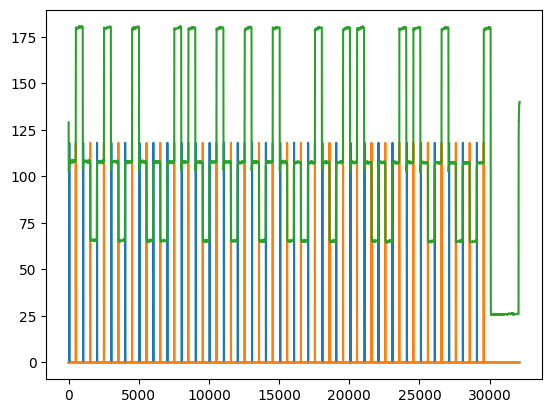

15 15 494.8
15 15 471.1333333333333
30 30 486.6333333333333



In [7]:
LEFT_MIN = 170

RIGHT_MAX = 77
RIGHT_MIN = 63

REST_MIN = 106
REST_MAX = 118


right_hand_ranges = []
left_hand_ranges = []
rest_ranges_1 = []

i = 1
for r in task1_ranges:
	tpr = pr[r[0]:r[1]]

	left_samples = tpr > LEFT_MIN
	left_first = getfirst(left_samples)
	left_last = getlast(left_samples)

	right_samples = np.logical_and(tpr > RIGHT_MIN, tpr < RIGHT_MAX)
	right_first = getfirst(right_samples)
	right_last = getlast(right_samples)
	right_indexes_wanted = np.where(tpr[right_first - 1] > RIGHT_MIN)[0]
	right_first = right_first[right_indexes_wanted[:15]]
	right_last = right_last[right_indexes_wanted[:15]]

	rest_samples = np.logical_and(tpr > REST_MIN, tpr < REST_MAX)
	rest_first = getfirst(rest_samples)
	rest_last = getlast(rest_samples)
	if rest_last[0] < rest_first[0]:
		if rest_last[0] < 500:
			rest_last = rest_last[1:]
		else:
			rest_first = np.concatenate([[rest_last[0] - 480], rest_first])
	rest_indexes_wanted = np.where(rest_last - rest_first > 100)[0]
	rest_first = rest_first[rest_indexes_wanted]
	rest_last = rest_last[rest_indexes_wanted]

	temp_left_ranges = np.array([left_first + r[0], left_last + r[0]]).T
	temp_right_ranges = np.array([right_first + r[0], right_last + r[0]]).T
	temp_rest_ranges = np.array([rest_first + r[0], rest_last + r[0]]).T
	left_hand_ranges.append(temp_left_ranges)
	right_hand_ranges.append(temp_right_ranges)
	rest_ranges_1.append(temp_rest_ranges)

	# change i to print some run
	if i == 10:
		plt.close()
		RIGHT = False
		LEFT = False
		REST = True
		if RIGHT:
			right_plot = np.zeros(tpr.shape)
			right_plot[right_first] = RIGHT_MAX
			plt.plot(right_plot)
			right_plot2 = np.zeros(tpr.shape)
			right_plot2[right_last] = RIGHT_MAX
			plt.plot(right_plot2)
		if LEFT:
			left_plot = np.zeros(tpr.shape)
			left_plot[left_first] = LEFT_MIN + 20
			plt.plot(left_plot)
			left_plot2 = np.zeros(tpr.shape)
			left_plot2[left_last] = LEFT_MIN + 20
			plt.plot(left_plot2)
		if REST:
			rest_plot = np.zeros(tpr.shape)
			rest_plot[rest_first] = REST_MAX
			plt.plot(rest_plot)
			rest_plot2 = np.zeros(tpr.shape)
			rest_plot2[rest_last] = REST_MAX
			plt.plot(rest_plot2)
		plt.plot(tpr)
		plt.show()
	i += 1

	print(len(left_first), len(left_last), np.average(left_last - left_first))
	print(len(right_first), len(right_last), np.average(right_last - right_first))
	print(len(rest_first), len(rest_last), np.average(rest_last - rest_first))
	print()

right_hand_ranges = np.concatenate(right_hand_ranges)
left_hand_ranges = np.concatenate(left_hand_ranges)
rest_ranges_1 = np.concatenate(rest_ranges_1)

15 15 503.6666666666667
15 15 471.4
30 30 501.23333333333335

15 15 505.2
15 15 470.46666666666664
30 30 499.9

15 15 511.8666666666667
15 15 469.3333333333333
30 30 497.3

15 15 512.2666666666667
15 15 468.93333333333334
30 30 496.46666666666664

15 15 515.9333333333333
15 15 471.73333333333335
30 30 488.06666666666666

15 15 519.8666666666667
15 15 467.8666666666667
30 30 490.03333333333336

15 15 515.2666666666667
15 15 466.46666666666664
30 30 491.03333333333336

15 15 521.2
15 15 469.26666666666665
30 30 482.46666666666664



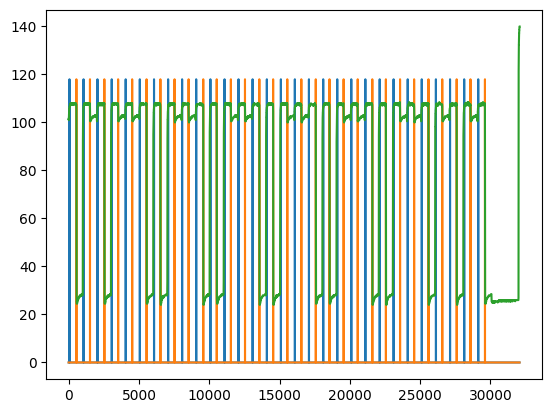

15 15 528.8666666666667
15 15 473.26666666666665
30 30 464.26666666666665

15 15 513.8666666666667
15 15 467.6
30 30 466.7



In [8]:
HANDS_MAX = 106.5
HANDS_MIN = 100

FEET_MAX = 35
FEET_MIN = 23

REST_MIN = 106
REST_MAX = 118


hand_ranges = []
feet_ranges = []
rest_ranges_2 = []

i = 1
for r in task2_ranges:
	tpr = pr[r[0]:r[1]]

	hands_samples = np.logical_and(tpr > HANDS_MIN, tpr < HANDS_MAX)
	hands_first = getfirst(hands_samples)
	hands_last = getlast(hands_samples)
	if hands_last[0] < hands_first[0]:
		hands_last = hands_last[1:]
	#hands_indexes_wanted = np.where(np.logical_and(tpr[hands_first - 1] > HANDS_MIN, tpr[hands_last + 1] > HANDS_MIN))[0]
	#hands_first = hands_first[hands_indexes_wanted]
	#hands_last = hands_last[hands_indexes_wanted]
	hands_indexes_wanted = np.where(hands_last - hands_first > 100)[0]
	hands_first = hands_first[hands_indexes_wanted]
	hands_last = hands_last[hands_indexes_wanted]

	feet_samples = np.logical_and(tpr > FEET_MIN, tpr < FEET_MAX)
	feet_first = getfirst(feet_samples)
	feet_last = getlast(feet_samples)
	if len(feet_first) > len(feet_last):
		feet_first = feet_first[:len(feet_last)]
	feet_indexes_wanted = np.where(np.logical_and(tpr[feet_first - 1] > FEET_MIN, tpr[feet_last + 1] > FEET_MIN))[0]
	feet_first = feet_first[feet_indexes_wanted[:15]]
	feet_last = feet_last[feet_indexes_wanted[:15]]
	if feet_last[14] - feet_first[14] > 500:
		feet_last[14] = feet_first[14] + 500


	rest_samples = np.logical_and(tpr > REST_MIN, tpr < REST_MAX)
	rest_first = getfirst(rest_samples)
	rest_last = getlast(rest_samples)
	if rest_last[0] < rest_first[0]:
		if rest_last[0] < 500:
			rest_last = rest_last[1:]
		else:
			rest_first = np.concatenate([[rest_last[0] - 480], rest_first])
	rest_indexes_wanted = np.where(rest_last - rest_first > 100)[0]
	rest_first = rest_first[rest_indexes_wanted]
	rest_last = rest_last[rest_indexes_wanted]

	temp_hand_ranges = np.array([left_first + r[0], left_last + r[0]]).T
	temp_feet_ranges = np.array([right_first + r[0], right_last + r[0]]).T
	temp_rest_ranges = np.array([rest_first + r[0], rest_last + r[0]]).T
	hand_ranges.append(temp_left_ranges)
	feet_ranges.append(temp_right_ranges)
	rest_ranges_2.append(temp_rest_ranges)

	# change i to print some run
	if i == 9:
		plt.close()
		HANDS = False
		FEET = False
		REST = True
		if HANDS:
			hands_plot = np.zeros(tpr.shape)
			hands_plot[hands_first] = HANDS_MAX
			plt.plot(hands_plot)
			hands_plot2 = np.zeros(tpr.shape)
			hands_plot2[hands_last] = HANDS_MAX
			plt.plot(hands_plot2)
		if FEET:
			feet_plot = np.zeros(tpr.shape)
			feet_plot[feet_first] = FEET_MAX
			plt.plot(feet_plot)
			feet_plot2 = np.zeros(tpr.shape)
			feet_plot2[feet_last] = FEET_MAX
			plt.plot(feet_plot2)
		if REST:
			rest_plot = np.zeros(tpr.shape)
			rest_plot[rest_first] = REST_MAX
			plt.plot(rest_plot)
			rest_plot2 = np.zeros(tpr.shape)
			rest_plot2[rest_last] = REST_MAX
			plt.plot(rest_plot2)
		plt.plot(tpr)
		plt.show()
	i += 1

	print(len(hands_first), len(hands_last), np.average(hands_last - hands_first))
	print(len(feet_first), len(feet_last), np.average(feet_last - feet_first))
	print(len(rest_first), len(rest_last), np.average(rest_last - rest_first))
	print()

hand_ranges = np.concatenate(hand_ranges)
feet_ranges = np.concatenate(feet_ranges)
rest_ranges_2 = np.concatenate(rest_ranges_2)

In [9]:
rest_ranges = np.concatenate([rest_ranges_1, rest_ranges_2])

left = np.zeros(len(left_hand_ranges), dtype=np.ndarray)
right = np.zeros(len(right_hand_ranges), dtype=np.ndarray)
both = np.zeros(len(hand_ranges), dtype=np.ndarray)
feet = np.zeros(len(feet_ranges), dtype=np.ndarray)
rest = np.zeros(len(rest_ranges), dtype=np.ndarray)

for i in range(len(left)):
	left[i] = data[:16, left_hand_ranges[i, 0]:left_hand_ranges[i, 1]]

for i in range(len(right)):
	right[i] = data[:16, right_hand_ranges[i, 0]:right_hand_ranges[i, 1]]

for i in range(len(both)):
	both[i] = data[:16, hand_ranges[i, 0]:hand_ranges[i, 1]]

for i in range(len(feet)):
	feet[i] = data[:16, feet_ranges[i, 0]:feet_ranges[i, 1]]

for i in range(len(rest)):
	rest[i] = data[:16, rest_ranges[i, 0]:rest_ranges[i, 1]]

output = {
	"left": left,
	"right": right,
	"both": both,
	"feet": feet,
	"rest": rest
}

import pickle

with open('data_segmented.pkl', 'wb') as f:
	pickle.dump(output, f)

In [10]:
ranges = {
	"left": left_hand_ranges,
	"right": left_hand_ranges,
	"both": hand_ranges,
	"feet": feet_ranges,
	"rest": rest_ranges
}

import pickle

with open('segments.pkl', 'wb') as f:
	pickle.dump(ranges, f)